# Lab 4 Report

Prepared by Zech Wolf

## 1. Loading the data

### 1.1 Read and clean the dataset

In [1]:
import pandas as pd

df = pd.read_csv("datasets/acs2017_census_tract_data.csv")

In [2]:
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

#Encode the strings as ints with a label encoder
le = LabelEncoder()
df.State = le.fit_transform(df.State)

df.drop(columns=["TractId", "County"], inplace=True) #get rid of tract ID and county

I decided to get rid of the county feature. Although there are reasons to think that county could be a helpful piece of information for classification (tracts in the same county might be similar), there are nearly 2000 counties in the dataset. Since the county needs to be one hot encoded before training the networks, this means that keeping counties in the dataset will increase the dimensionality by almost 2000, and make the dataset much more sparse. I think the downsides of increasing the dimensionality will outweigh any potential benefit of having county as a feature.

I also decide to get rid of the tract ID. This is just a unique identifier value for each census tract. As far as I can tell there is nothing informative about the numerical value, so this feature is probably not important for classification, and would also increase the dimensionality substantially.

### 1.2 Quantizing child poverty

In [4]:
print(df.ChildPoverty.describe())

df["target"] = pd.qcut(x=df.ChildPoverty, q=4, labels=False)

count    72718.000000
mean        21.148476
std         18.572714
min          0.000000
25%          6.200000
50%         16.300000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64


One way to balance the target as best as possible would be to use the quartiles of child poverty. Looking at the quartile thresholds, this quantization could be suitable, if we are more focused on contrasting very low levels of poverty, to much higher levels of poverty. The first three classes would inhabit the range of 0% - 31.3% poverty, meaning the subdivisons would cover very low levels of poverty, mild levels of poverty, and concerning levels of poverty. The final class would have a much larger range, from 31.6% - 100%. Although this range is quite large, 31.6% of children living in poverty is definitely significant. Depending on the business case, 31.6% and above could be a threshold where more extreme action needs to take place to combat poverty.

Assuming such a business case, I will use quartiles as the quantization thresholds for the target variable.

### 1.3 Train-test split

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

#Splitting as df for now to make manipulation easier
#Need to get the numpy arrays before fitting the models though
df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.target, random_state=1234)

#Get rid of child poverty as a feature
df_train.drop(columns="ChildPoverty", inplace=True)
df_test.drop(columns="ChildPoverty", inplace=True)

#Check the balance of the target
print(np.bincount(df_train["target"]))
print(np.bincount(df_test["target"]))

[14583 14537 14518 14536]
[3646 3634 3630 3634]


It is important that the classes are balanced in the training set, especially with the assumption that all classes are equally important in this scenario. Ideally, a model should have about the same number of samples per class to train on, so it can learn to recognize all classes equally well. An imbalanced training set means the model could become very good at classifying the majority class, but fail to recognize the minority. The testing set should not be balanced by class though. Instead, the testing set should be representative of the class distribution that would be seen in a deployment of the model, so that the performance metrics on the testing set would be a reliable estimate of the performance that would be achieved by a real deployment. In this case, the testing set will happen to be balanced because that is the distribution we would expect to see in a real deployment, given the quantization thresholds.

## 2. Preprocessing and Initial Modeling

### 2.1 Two-Layer Perceptron Implementation

This implementation uses:
* Binary cross entropy
* Mini batching
* Glorot and He weight initialization
* Vectorized gradient computation

In [6]:
from scipy.special import expit

#Taken from different examples in the class notebook
class TLPBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [7]:
import sys
class TwoLayerPerceptron(TLPBase):
    def __init__(self, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for k in range(self.epochs):

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2

            self.cost_.append(mini_cost)

### 2.2 Testing procedure

I define a function to fit a neural network on the training data and predict on the testing set. The accuracy is printed alongside the loss curve.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

sns.set_theme()

def plot_cost(cost_avg, show=True):
    sns.lineplot(x=range(len(cost_avg)), y=cost_avg)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    if show: plt.show()

def eval_nn(nn):
    #Get the numpy arrays
    X_train = df_train.drop(columns="target").to_numpy()
    X_test = df_test.drop(columns="target").to_numpy()
    y_train = df_train["target"].to_numpy()
    y_test = df_test["target"].to_numpy()

    nn.fit(X_train, y_train, print_progress=1)
    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    cost_avg = np.apply_along_axis(np.mean, 1, nn.cost_)
    plot_cost(cost_avg)
    print(f"The network achieved an accuracy of: {acc}")

    return cost_avg, acc, y_pred

### 2.3 Performance on unprocessed data

In [9]:
tlp = TwoLayerPerceptron(C=.01, epochs=200, minibatches=len(df_train)/10) #use the same object and retrain on each dataset
performance = list() #list of tuples with performance info for each network

Epoch: 50/50

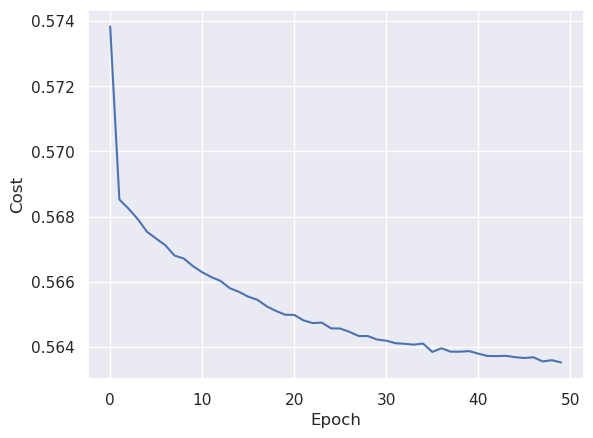

The network achieved an accuracy of: 0.24986248624862487


In [19]:
performance.append(("No preprocessing",) + eval_nn(tlp))

### 2.4 Performance on normalized continuous features

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Normalize the features
for col in df_train.columns:
    if col not in ["State", "target"]: #dont scale target or categorical features
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
        df_test[col] = scaler.fit_transform(df_test[col].values.reshape(-1,1)) #fit scaler separately to avoid data snooping

Epoch: 50/50

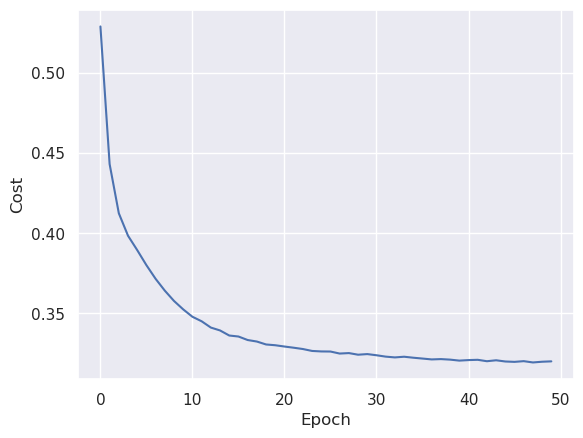

The network achieved an accuracy of: 0.6974009900990099


In [21]:
#Test the network
performance.append(("Normalization",) + eval_nn(tlp))

### 2.5 Performance on OHE and normalized features

In [12]:
col = "State" #only state needs to be ohe

#Get the encodings
ohe_train = pd.get_dummies(df_train[col], drop_first=True)
ohe_test = pd.get_dummies(df_test[col], drop_first=True)

#Drop the original columns
df_train.drop(columns=[col], inplace=True)
df_test.drop(columns=[col], inplace=True)

#Add in the OHE columns
df_train = pd.concat([ohe_train, df_train], axis=1)
df_test = pd.concat([ohe_test, df_test], axis=1)

Epoch: 50/50

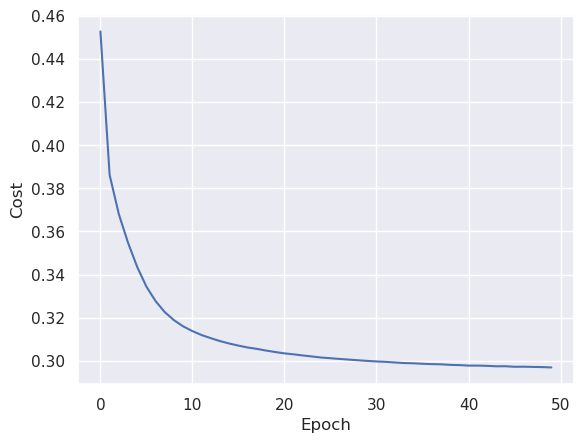

The network achieved an accuracy of: 0.7279290429042904


In [23]:
performance.append(("Normalization and OHE",) + eval_nn(tlp))

### 2.6 Preprocessing technique comparison

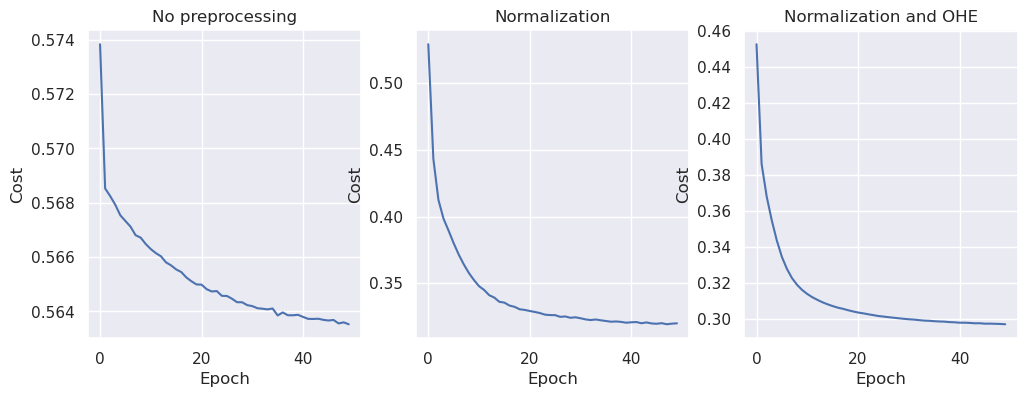

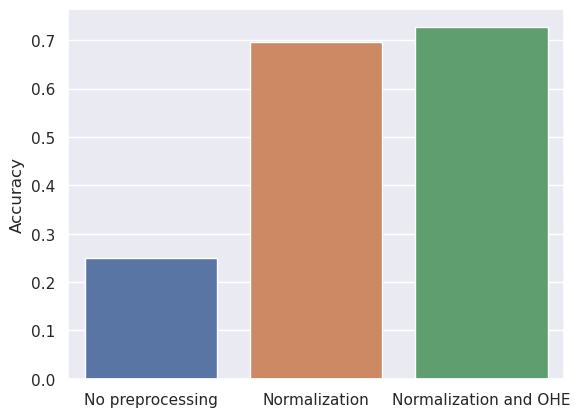

In [26]:
plt.figure(figsize=(12,4))

i = 1
accs = list()
for p in performance:
    label = p[0]
    cost = p[1]
    accs.append(p[2])

    plt.subplot(1,3,i)
    plot_cost(cost, show=False)
    plt.title(label)

    i += 1

plt.show()

sns.barplot(x=[p[0] for p in performance], y=accs)
plt.ylabel("Accuracy")
plt.show()

Based on accuracy, the neural network performs the best when the dataset has been normalized, and categorical features are one hot encoded. A statistical comparison is still needed to see if these differences are statistically significant.

#### McNemar's Test

I use McNemar's test as a statistical comparison between the models. The critical value for a 95% CI is $3.841$. The performance of the models are different with statistical significance if the chi squared statistic of the contingency matrix is greater than the critical value.

In [11]:
#Get the numpy arrays from the final df for use in the rest

X_train = df_train.drop(columns="target").to_numpy()
X_test = df_test.drop(columns="target").to_numpy()
y_train = df_train["target"].to_numpy()
y_test = df_test["target"].to_numpy()

In [15]:
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

In [31]:
y_preds = [p[3] for p in performance]

#Compare no preprocessing to normalization only
mc = mcnemar(y_preds[0], y_preds[1], y_test)
print(f"No preprocessing vs. Normalization only: {mc}")

No preprocessing vs. Normalization only: 5422.36128536679


The result of McNemar's test is far greater than 3.841 while comparing no preprocessing to normalization only. Given the higher accuracy, this means that normalization is statistically better than no preprocessing.

In [32]:
#Same test for normalization only vs norm and ohe
mc = mcnemar(y_preds[1], y_preds[2], y_test)
print(f"Normalization only vs. Normalization and OHE: {mc}")

Normalization only vs. Normalization and OHE: 105.51021505376345


McNemar's test shows that we can reject the null hypothesis that the performance is the same between these two models. Given the higher accuracy, this means that the model using normalization and OHE is statistically better than just normalization (and transitively, the best model of the three tested here).

I think the reason for this is that normalization approximately equalizes the dynamic range for all features, and the one hot encoding corrects the problem of integer label encoding. Without any normalization, the features with the highest dynamic ranges would have a disproportionate impact on the gradient calculations for the weights during gradient descent. Normalizing to z-scores ensures that no feature's impact is disproportionate. The problem with label encoding (State column) in the unprocessed dataset is that the model learns that the value of the integer is important. However, by creating a sparse matrix to represent the categorical data, one hot encoding treats the feature as a unique identifier to correct this problem.

## 3. N-layer perceptron

### 3.1 Implementation

I use a single class to create a neural network with the number of layers given in the constructor. The constructor also takes an adaptive learning technique (and associated hyperparameters), default None

In [12]:
class MLPClassifier:
    def __init__(self, n_layers=2, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 shuffle=True, minibatches=1, adapt=None, gamma=.001,
                 beta1=0.9, beta2=0.999):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.n_layers = n_layers
        self.adapt = adapt
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""

        W = []
        b = [] #weights and biases for each layer stored in a list, biases has placeholder at start to help with indexing

        #Init weights for input layer
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))
        W.append(W1)
        b1 = np.zeros((self.n_hidden, 1))
        b.append(b1)

        #Init weights for hidden layers
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_hidden))
        for n in range(1,self.n_layers - 1):
            Wn = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden))
            bn = np.zeros((self.n_hidden, 1))
            W.append(Wn)
            b.append(bn)
        
        #Init weights for the output layer
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        Wf = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        W.append(Wf)

        #Final bias
        bf = np.zeros((self.n_output_, 1))
        b.append(bf)
        
        return W, b
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        s = 0
        for Wn in W: #get the sum of the terms from each weight matrix
            s += np.mean(Wn[:, 1:] ** 2)

        return (lambda_/2.0) * np.sqrt(s)
    
    def _cost(self, Af, Y_enc, W): #Af is the activations of the final layer
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(Af)+(1-Y_enc)*np.log(1-Af))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W, b):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W : array of weight matrices for each layer
        b : array of bias vectors for each layer
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A = [X.T] #start with the input layer activation
        for n in range(self.n_layers):
            Zn = W[n] @ A[n] + b[n]
            A_next = self._sigmoid(Zn)
            A.append(A_next)

        return A
    
    def _get_gradient(self, A, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V = [A[-1] - Y_enc] #list of sensitivities in descending layer order
        for n in range(1,self.n_layers):
            Vn = A[-n-1]*(1-A[-n-1])*(W[-n].T @ V[n-1]) #A is in ascending order, use negative indexing
            V.append(Vn)


        gradW = []
        gradb = [] #store the gradients for each weight and bias

        V.reverse() #get V in the same layer order as A 
        for n, Vn in enumerate(V):
            gradWn = (Vn @ A[n].T) + (W[n] * self.l2_C) #regularization
            gradbn = np.sum(Vn, axis=1).reshape((-1,1))
            gradW.append(gradWn)
            gradb.append(gradbn)

        return gradW, gradb
    
    def predict(self, X):
        """Predict class labels"""
        A = self._feedforward(X, self.W, self.b)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()

        self.cost_ = []
        self.gradW_ = np.empty((self.epochs,self.n_layers)) #stores average gradient magnitude of each layer
        for k in range(self.epochs):

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[-1], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW, gradb = self._get_gradient(A, Y_enc[:,idx], self.W)

                if self.adapt == "adagrad":
                    Gk_prev = [np.zeros(w.shape) for w in gradW]
                elif self.adapt == "adam":
                    Mk_prev = [np.zeros(w.shape) for w in gradW]
                    Vk_prev = [np.zeros(w.shape) for w in gradW]

                #Gradient updates
                for i in range(len(self.W)):

                    ### NO ADAPTIVE LEARNING ###
                    if self.adapt is None:
                        self.W[i] -= self.eta * gradW[i]
                    
                    ### ADAGRAD LEARNING ###
                    elif self.adapt == "adagrad":
                        Gk = self.gamma * Gk_prev[i] + gradW[i]*gradW[i]
                        rho_k = ( 1/np.sqrt( Gk + 1e-8 ) ) * gradW[i]
                        self.W[i] -= self.eta * rho_k
                        
                        Gk_prev[i] = Gk
                    
                    ### EXCEPTIONAL WORK - ADAM LEARNING ###
                    elif self.adapt == "adam":
                        Mk = self.beta1 * Mk_prev[i] + (1 - self.beta1)*gradW[i]
                        Vk = self.beta2 * Vk_prev[i] + (1 - self.beta2)*gradW[i]*gradW[i]
                        Mk_hat = Mk / (1 - self.beta1**(k+1))
                        Vk_hat = Vk / (1 - self.beta2**(k+1)) #avoid k=0
                        self.W[i] -= self.eta * (Mk_hat / (np.sqrt(Vk_hat) + 1e-8))
                        #these equations are implemented based on the AdaM paper pseudocode

                        Mk_prev[i] = Mk
                        Vk_prev[i] = Vk
                    
                    self.b[i] -= self.eta * gradb[i] #bias update
                    self.gradW_[k,i] = np.mean(np.abs(gradW[i])) + np.mean(np.abs(gradb[i])) # record avg grad magnitude
                        

            self.cost_.append(mini_cost)

    def plot_grad_(self, show=True):
        for n in range(self.n_layers):
            sns.lineplot(x=range(self.epochs), y=self.gradW_[:,n], label=f"Layer {n+1}")

        plt.xlabel("Epoch")
        plt.ylabel("Average gradient magnitude")
        plt.legend()
        if show: plt.show()

#### Evaluation procedure

In [13]:
def eval_mlp(n_layers, adapt=None, epochs=50):
    """Fit the MLP and plot the gradient magnitudes and loss curve, report the accuracy"""
    mlp = MLPClassifier(epochs=epochs, n_layers=n_layers, minibatches=len(X_train)/50, adapt=adapt, C=.001, gamma=.9)
    mlp.fit(X_train, y_train, print_progress=1)
    
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    plt.figure(figsize=(10,6))
    cost_avg = np.apply_along_axis(np.mean, 1, mlp.cost_)
    plt.subplot(1,2,1)
    plot_cost(cost_avg, show=False)
    plt.title("Loss curve")

    plt.subplot(1,2,2)
    mlp.plot_grad_(show=False)
    plt.title("Gradient magnitudes")
    plt.show()
    print(f"The network achieved an accuracy of {acc}")

### 3.2 Three layer perceptron

Epoch: 50/50

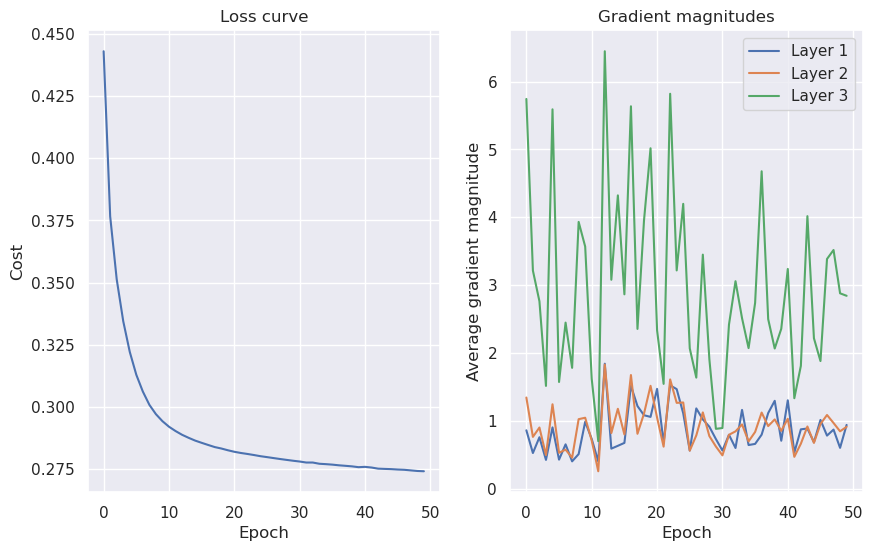

The network achieved an accuracy of 0.7358360836083608


In [15]:
eval_mlp(3)

### 3.3 Four layer perceptron

Epoch: 50/50

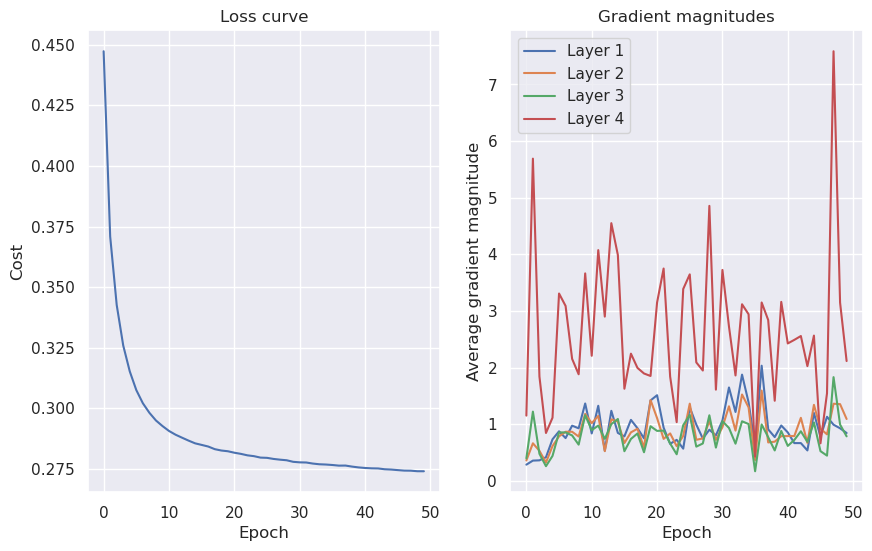

The network achieved an accuracy of 0.7363861386138614


In [38]:
eval_mlp(4)

### 3.4 Five Layer perceptron

Epoch: 50/50

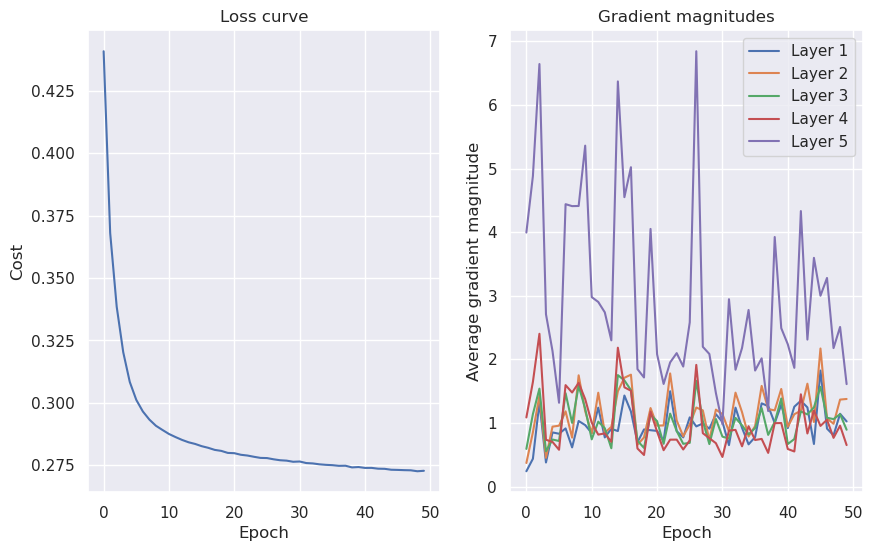

The network achieved an accuracy of 0.7331545654565457


In [39]:
eval_mlp(5, epochs=50)

### 3.5 Adaptive learning with AdaGrad

AdaGrad is an adaptive learning technique that changes the learning rate proportionally to the inverse of the accumulated gradient magnitude squared. In each update iteration, the current gradient magnitude squared is accumulated into $G_k$, which stores the sums of the previous squared gradient magnitudes scaled by a hyperparameter, $\gamma$. This is used to calculate $\rho_k$, the momentum for iteration $k$, which effects how sharply the gradient will update.

AdaGrad is implemented in the MLPClassifier in section 3.1 (in the $\textit{fit}$ function). I compare the performance of the network with no adaptive learning to the performance using AdaGrad.

Epoch: 50/50

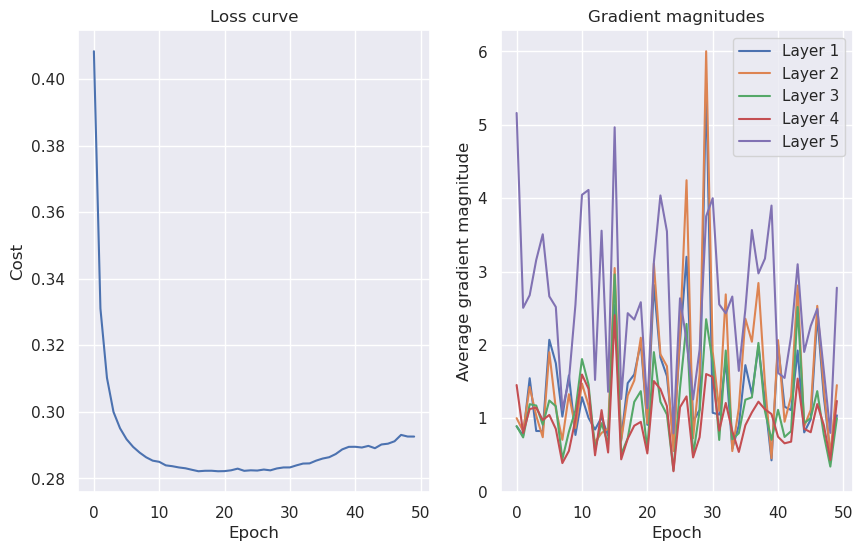

The network achieved an accuracy of 0.7327420242024203


In [44]:
eval_mlp(5, adapt="adagrad", epochs=50)

### 3.6 Comparing no adaptive learning to AdaGrad

One notable difference is that AdaGrad converges, but then seems to overshoot the local minimum and wander off, resulting in the cost function increasing slightly after about 20 epochs. AdaGrad also seems to cause the model to converge faster, as the slope of the cost function vs. epoch looks much steeper in the beginning. This is probably because the momentum is high at the beginning as the magnitude of the gradient is larger. The overall accuracy is quite similar to the regular five layer network though. A full comparison will show if either model is better or worse.

In [22]:
mlp = MLPClassifier(epochs=50, n_layers=5, C=.001, minibatches=len(X_train)/100)
mlp_ada = MLPClassifier(epochs=20, n_layers=5, C=.001, minibatches=len(X_train)/100, adapt="adagrad", gamma=.9) #using 20 epochs for convergence

mlp.fit(X_train, y_train)
mlp_ada.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_pred_ada = mlp_ada.predict(X_test)

print(f"Accuracy with no adaptive learning {accuracy_score(y_test, y_pred)}")
print(f"Accuracy with AdaGrad {accuracy_score(y_test, y_pred_ada)}")

Accuracy with no adaptive learning 0.7290291529152916
Accuracy with AdaGrad 0.7318481848184818


#### McNemar's test

The accuracies are very similar between the two models, with AdaGrad performing slightly better. McNemar's test will determine if this is a statistically significant difference. The result must be greater than the critical value of $3.841$ to reject the null hypothesis

In [23]:
mc = mcnemar(y_pred, y_pred_ada, y_test)
print(f"No adaptive learning vs. AdaGrad: {mc}")

No adaptive learning vs. AdaGrad: 1.1895910780669146


The result of McNemar's test is not greater than the critical value. This means that there is no statistically significant difference between the performance of the model with and without AdaGrad.

## 4. Exceptional Work - adaptive learning with AdaM

AdaM is implemented in section 3.1 in the fit function. AdaM uses four hyperparameters:
* $\eta = 0.001$  (the same value I have used throughout)
* $\beta_1 = 0.9$
* $\beta_2 = 0.999$
* $\epsilon = 10^{-8}$

These values were chosen based on the recommendations of the authors of the paper proposing AdaM

https://arxiv.org/abs/1412.6980

Epoch: 50/50

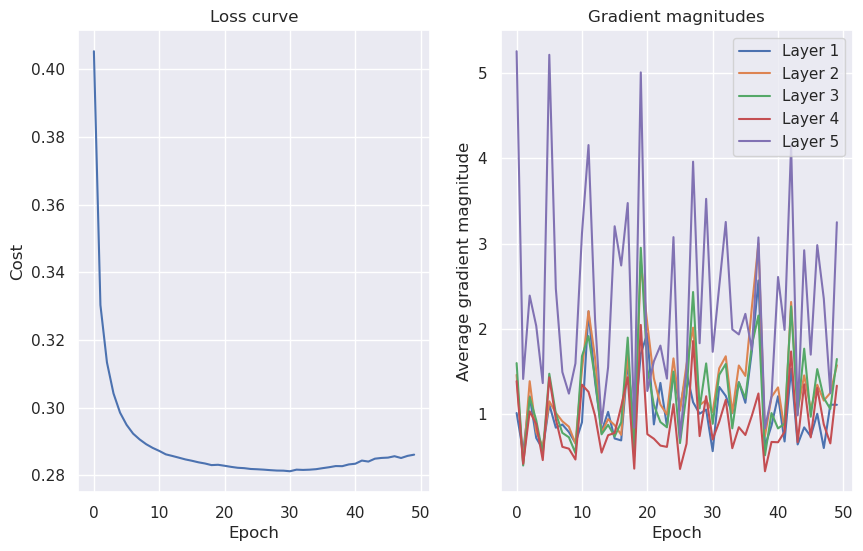

The network achieved an accuracy of 0.7290979097909791


In [24]:
eval_mlp(5, adapt="adam")

Similar to AdaGrad, AdaM seems to converge faster than the network without any adaptive techniques. AdaM performs about as well as the five layer network without adaptive learning. We can repeat McNemar's test to determine if it is statistically better or worse.

In [25]:
mlp = MLPClassifier(epochs=50, n_layers=5, C=.001, minibatches=len(X_train)/100)
mlp_adam = MLPClassifier(epochs=30, n_layers=5, C=.001, minibatches=len(X_train)/100, adapt="adam") #using 30 epochs for convergence

mlp.fit(X_train, y_train)
mlp_adam.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_pred_adam = mlp_adam.predict(X_test)

print(f"Accuracy with no adaptive learning {accuracy_score(y_test, y_pred)}")
print(f"Accuracy with AdaM {accuracy_score(y_test, y_pred_adam)}")

Accuracy with no adaptive learning 0.7347359735973598
Accuracy with AdaM 0.7304042904290429


In [62]:
mc = mcnemar(y_pred, y_pred_adam, y_test)
print(f"No adaptive learning vs. AdaM: {mc}")

No adaptive learning vs. AdaM: 2.395039858281665


McNemar's test shows that there is no statistically significant difference. So for this scenario using a five layer network, neither Adam or AdaGrad is statistically better than a network without adaptive learning. Even so, both adaptive techniques appear to make the model converge faster, which could be an advantage in a scenario where training time is a concern, and the training set is larger.